### This notebook is used for loading the best model that we got from **Creating_Model** Notebook and using that model we will do some live predictions 

## Importing all the necessary libraries for this project

1) Python Standard Libraries
* os → file/directory handling.
* `sys` - sometimes used for environment/path control.
* `time` - measure runtime (e.g., record duration).
* `math` - simple math ops (floor, log, etc.).
* `warnings` - suppress warnings during runtime.
* `base64` (b64decode) - decode audio bytes that come from the browser (JS sends audio as base64).

2) Data % Visualization Libraries
* `numpy` - array ops, convert raw audio (bytes → np.float32).
* `matplotlib.pyplo` - visualize waveform/spectrograms after recording.

3) PyTorch Core
* `torch` - core tensor library, run model on CPU/GPU.
* `nn` - build layers if needed (Conv2d, Linear).
* `F` - stateless functions like F.softmax to turn logits into probabilities.

4) Audio-Specific (TorchAudio)
* `torchaudi`o - load/process audio (waveform, sample rate).
* `T (transforms)` - resample to 16kHz, convert to log-mel spectrogram.
* `AF (functional)` - compute delta (Δ) and delta-delta (Δ²) features.

5) Colab / Browser Integration
* `google.colab.output` - creates a bridge from browser to Python (capture mic in Colab).
* `Javascript, display` - injects JS code inside Colab cell to access the microphone.

6) Utilities
* `Pathlib` - clean way to handle directories (ARTIFACTS / "best_model.pth").

In [12]:
import os, sys, time, math, warnings
from pathlib import Path

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio.functional as AF
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript, display
import numpy as np
import matplotlib.pyplot as plt

## We will use the same environment as we did in **Creating_Model** notebook

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA:", torch.version.cuda, "| GPU:", torch.cuda.get_device_name(0))
    # quick sanity
    x = torch.randn(1024,1024,device="cuda"); y = torch.randn(1024,1024,device="cuda")
    torch.cuda.synchronize(); t0 = time.time(); _ = x@y; torch.cuda.synchronize()
    print(f"GPU sanity matmul: {(time.time()-t0)*1000:.1f} ms")

Device: cuda
CUDA: 12.6 | GPU: Tesla T4
GPU sanity matmul: 152.8 ms


## Defininf the same path where out directory is

In [3]:
PROJECT_ROOT = Path("/content/drive/MyDrive/NLP_Project")
ARTIFACTS    = PROJECT_ROOT / "artifacts"
CKPT_DIR     = ARTIFACTS / "checkpoints"

BEST_CKPT    = CKPT_DIR / "best_by_val_f1.pt"  # contains weights + label2id
FINAL_PTH    = ARTIFACTS / "final_model.pth"   # weights only (no label map)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("ARTIFACTS   :", ARTIFACTS)
print("BEST_CKPT   :", BEST_CKPT.exists())
print("FINAL_PTH   :", FINAL_PTH.exists())

PROJECT_ROOT: /content/drive/MyDrive/NLP_Project
ARTIFACTS   : /content/drive/MyDrive/NLP_Project/artifacts
BEST_CKPT   : True
FINAL_PTH   : True


### Model Hyperparameters (top-level constants)

* `IN_CH = 3`
We feed 3-channel spectrograms to the CNN: [log-mel, delta, delta²]. This gives the model both the spectral energy and its short-term dynamics.

* `BASE_CH = 48`
The number of feature maps in the first conv block. Higher than 32 to add model capacity (helped your accuracy).

* `P_DROP = 0.10`
Dropout probability used in blocks and head: regularizes the network to reduce overfitting.


## DepthwiseSeparableConv (DS-Conv) block

What it is: a lightweight alternative to a standard 3×3 conv.

Inside the block:

* Depthwise 3×3 conv `(groups=in_ch)`
Applies one 3×3 filter per input channel (no channel mixing). It learns spatial patterns (time–frequency patterns) cheaply.

* BatchNorm + ReLU
Stabilizes activations and speeds convergence; ReLU adds nonlinearity.

* Pointwise 1×1 conv
Mixes info across channels (this is where features combine).

* BatchNorm + ReLU and Dropout(p_drop)
BN + ReLU again, then optional dropout to regularize.

Why DS-Conv: gives you most of the accuracy of a full conv with far fewer parameters/compute — great for real-time KWS.

In [5]:
IN_CH   = 3     # [logmel, delta, delta2]
BASE_CH = 48    # widened as per your improved run
P_DROP  = 0.10

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.dw   = nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dwbn = nn.BatchNorm2d(in_ch)
        self.pw   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.pwbn = nn.BatchNorm2d(out_ch)
        self.drop = nn.Dropout(p_drop) if p_drop > 0 else nn.Identity()
    def forward(self, x):
        x = F.relu(self.dwbn(self.dw(x)), inplace=True)
        x = F.relu(self.pwbn(self.pw(x)), inplace=True)
        return self.drop(x)

In [ ]:
class DSCNN_KWS(nn.Module):
    """Input: [B,3,40,T] -> logits [B,num_classes]"""
    def __init__(self, num_classes: int, in_ch: int = IN_CH, base_ch: int = BASE_CH, p_drop: float = P_DROP):
        super().__init__()

        # First 3×3 conv lifts channels from 3 → BASE_CH (48), learns low-level time-freq edges, BN + ReLU for stability and nonlinearity.
        self.stem = nn.Sequential( 
            nn.Conv2d(in_ch, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )
        ch = base_ch
        self.block1 = DepthwiseSeparableConv(ch,   ch,   stride=1, p_drop=p_drop) # keeps spatial size, refines features
        self.block2 = DepthwiseSeparableConv(ch,   ch*2, stride=2, p_drop=p_drop); ch *= 2 # stride=2 → downsamples time/frequency by ~2×, and doubles channels (48→96).
        self.block3 = DepthwiseSeparableConv(ch,   ch,   stride=1, p_drop=p_drop) # refines at the higher channel count.
        self.block4 = DepthwiseSeparableConv(ch,   ch*2, stride=2, p_drop=p_drop); ch *= 2 # downsamples again (96→192 channels).

        # Head + Classification
        self.head_bn = nn.BatchNorm2d(ch)
        self.head_dp = nn.Dropout(p_drop)
        self.fc = nn.Linear(ch, num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x); x = self.block2(x)
        x = self.block3(x); x = self.block4(x)
        x = F.relu(self.head_bn(x), inplace=True)
        x = self.head_dp(x)
        x = x.mean(dim=(-2, -1))  # global average pool over (freq,time)
        return self.fc(x)

## Loading the model 

In [6]:
# Ensures you actually have a saved model to load:
# BEST_CKPT (checkpoint with extra metadata like labels & epoch), or
# FINAL_PTH (just weights).
assert BEST_CKPT.exists() or FINAL_PTH.exists(), "No saved model found in artifacts."

label2id = None

# Loads the checkpoint that includes:
#model_state (weights),
#label2id (mapping from class name → index),
#training metadata (epoch, best_val_f1).
#Rebuilds the model with the correct num_classes.
#Moves model to the right device (CPU/GPU).
#Restores weights via load_state_dict.
#Prints which epoch it came from and the best validation F1.

if BEST_CKPT.exists():
    ckpt = torch.load(BEST_CKPT, map_location=device)
    label2id = ckpt["label2id"]
    id2label = {i: lbl for lbl, i in label2id.items()}
    num_classes = len(label2id)
    model = DSCNN_KWS(num_classes=num_classes).to(device)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best checkpoint: epoch={ckpt['epoch']}, best val F1={ckpt['best_val_f1']:.4f}")
else: # If you don’t have the checkpoint, we load raw weights from final_model.pth but raw weights don’t include the label map, so we require label2id.json saved during training.
    # FINAL_PTH fallback (only weights). You MUST provide label2id somehow (e.g., store to JSON during training).
    # Here we try to load label2id saved alongside training (optional improvement).
    label_json = ARTIFACTS / "label2id.json"
    assert label_json.exists(), "label2id.json not found. Save label2id during training or use BEST_CKPT."
    import json
    label2id = json.load(open(label_json))
    id2label = {i: lbl for lbl, i in label2id.items()}
    num_classes = len(label2id)
    model = DSCNN_KWS(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(FINAL_PTH, map_location=device))
    print("Loaded final_model.pth + label2id.json")

model.eval() # Disables dropout and uses running statistics for batch norm — required for stable predictions.
print("Classes:", num_classes)
print("Example labels:", sorted(list(label2id.keys()))[:10], "...")

Loaded best checkpoint: epoch=34, best val F1=0.8874
Classes: 36
Example labels: ['__silence__', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow'] ...


## Feature extraction pipeline

In [9]:
SAMPLE_RATE = 16000 # target sample rate (16 kHz, standard for speech)
CLIP_SECONDS = 1.0 # clip length (1 sec per sample)
TARGET_LEN  = int(SAMPLE_RATE * CLIP_SECONDS) # total samples (16000)
N_MELS      = 40 # mel filterbank size

mel_extractor = T.MelSpectrogram( # This is same as we created while creating the model
    sample_rate=SAMPLE_RATE,
    n_fft=400, hop_length=160, win_length=400,
    n_mels=N_MELS, f_min=20, f_max=7600, power=2.0,
    window_fn=torch.hann_window
)
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=80.0)


# Audio Loading & Preprocessing
def load_wav(path, target_sr=SAMPLE_RATE): # Ensures consistent format: mono, 16 kHz.
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1:
        wav = torch.mean(wav, dim=0, keepdim=True)
    if sr != target_sr:
        wav = T.Resample(sr, target_sr)(wav)
    return wav

def pad_or_trim(wav, num_samples=TARGET_LEN): # Clips/pads every waveform to exactly 1 second (16k samples).
    n = wav.shape[-1]
    return torch.nn.functional.pad(wav, (0, num_samples - n)) if n < num_samples else wav[..., :num_samples]

@torch.no_grad()
def wav_to_logmel3(wav: torch.Tensor) -> torch.Tensor:
    """
    Returns [3, 40, T]: [logmel, delta, delta2] with per-sample channel-wise normalization.
    """
    mel = mel_extractor(wav)                 # [1, 40, T]
    logmel = amplitude_to_db(mel + 1e-10)    # [1, 40, T]
    delta  = AF.compute_deltas(logmel, win_length=5)
    delta2 = AF.compute_deltas(delta,   win_length=5)
    feat = torch.cat([logmel, delta, delta2], dim=0)  # [3, 40, T]

    # per-sample channel normalization
    mean = feat.mean(dim=(-2, -1), keepdim=True)
    std  = feat.std(dim=(-2, -1), keepdim=True).clamp_min(1e-5)
    feat = (feat - mean) / std
    return feat

This function `record_audio` opens browser’s mic permission prompt from Colab, records ~seconds of audio, and saves it as a WAV file on the Colab VM (default: /content/mic.wav). Then we will pass that WAV into your preprocessing → model for a prediction.

Step-by-step: how it works

1) **Injects JavaScript into the notebook**
* `Javascript(...)` defines an async `record(sec)` function that uses the Web Media APIs in your browser.

2) **Requests microphone access**
* `navigator.mediaDevices.getUserMedia({ audio: true })` shows the browser permission dialog. Recording won’t start unless you allow it.

3) **Records audio for N seconds**
* Creates a `MediaRecorder(stream)`.
* Collects audio `chunks` while recording.
* Waits `sec * 1000` ms, then stops the recorder.

4) **Packages the recording as a WAV**
* Combines chunks into a `Blob` with MIME `'audio/wav; codecs=PCM'`.
* Converts the blob to an ArrayBuffer → Base64 data URL `(data:audio/wav;base64,...)`.

5) **Returns the audio to Python**
* `output.eval_js(...)` runs the JS and returns that Base64 data URL to Python.
* Python decodes it with `b64decode`, writes bytes to disk at `out_wav`.

6) **Returns the file path**
* The function returns the string path so you can immediately load it with `torchaudio.load`.

In [11]:
def record_audio(seconds: float = 1.2, out_wav: str = "/content/mic.wav") -> str:
    """
    Pops a mic permission dialog in your browser, records `seconds`, saves WAV to out_wav.
    """
    js = Javascript(r"""
    async function record(sec) {
      const stream = await navigator.mediaDevices.getUserMedia({audio: true});
      const mediaRecorder = new MediaRecorder(stream);
      let chunks = [];
      mediaRecorder.ondataavailable = e => chunks.push(e.data);
      mediaRecorder.start();
      await new Promise(r => setTimeout(r, sec * 1000));
      mediaRecorder.stop();
      await new Promise(r => mediaRecorder.onstop = r);
      const blob = new Blob(chunks, {'type': 'audio/wav; codecs=PCM'});
      const arrayBuffer = await blob.arrayBuffer();
      const base64 = btoa(String.fromCharCode(...new Uint8Array(arrayBuffer)));
      return 'data:audio/wav;base64,' + base64;
    }
    """)
    display(js)
    data_url = output.eval_js(f"record({float(seconds)})")
    wav_bytes = b64decode(data_url.split(',')[1])
    with open(out_wav, "wb") as f:
        f.write(wav_bytes)
    return out_wav

print("Mic recorder ready — call record_audio(seconds=1.2)")

Mic recorder ready — call record_audio(seconds=1.2)


In [13]:
SILENCE_LABEL = "__silence__"
ENERGY_SILENCE_DBFS = -50.0   # change to -55.0 if you want a stricter silence threshold

def rms_db(wav: torch.Tensor) -> float:
    rms = (wav.pow(2).mean().sqrt() + 1e-12).item()
    return 20.0 * math.log10(rms + 1e-12)

@torch.no_grad() 
def predict_wav(path: str, topk: int = 5, plot: bool = True): # This function is end-to-end inference wrapper for running a single WAV file through your trained DSCNN model.
    # 1) Load & standardize
    wav = load_wav(path) # Loads the audio (mono, resampled to 16kHz).
    wav = pad_or_trim(wav, TARGET_LEN) # Pads/trims to exactly 1.0s (matches training).

    # 2) Silence gate (energy-based, optional)
    level_db = rms_db(wav)
    maybe_silence = (level_db < ENERGY_SILENCE_DBFS)

    # 3) Features -> model -> softmax
    spec3 = wav_to_logmel3(wav)               # [3, 40, T]
    X = spec3.unsqueeze(0).to(device)         # [1, 3, 40, T]
    logits = model(X)
    proba  = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    # 4) Top-k
    idxs = np.argsort(-proba)[:topk]
    labels = [id2label[i] for i in idxs]
    scores = [float(proba[i]) for i in idxs]

    # Optional: force silence if energy is extremely low
    if maybe_silence and SILENCE_LABEL in id2label.values():
        sil_id = {v:k for k,v in id2label.items()}[SILENCE_LABEL]
        labels[0] = SILENCE_LABEL
        scores[0] = float(proba[sil_id])

    # 5) Print
    print(f"\nFile: {path}")
    print(f"RMS level: {level_db:.1f} dBFS  | Silence gate: {ENERGY_SILENCE_DBFS:.1f} dBFS")
    print("Top predictions:")
    for i, (lbl, sc) in enumerate(zip(labels, scores), 1):
        print(f"  {i:>2}. {lbl:20s}  {sc:6.3f}")

    # 6) Visuals
    if plot:
        fig = plt.figure(figsize=(10, 2.2))
        x = np.arange(wav.shape[-1]) / SAMPLE_RATE
        plt.title("Recorded Waveform")
        plt.plot(x, wav.squeeze(0).numpy())
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.tight_layout(); plt.show()

        fig = plt.figure(figsize=(8, 4))
        plt.title("Log-Mel (channel 0)")
        plt.imshow(spec3[0].numpy(), aspect="auto", origin="lower")
        plt.xlabel("Frames"); plt.ylabel("Mel bins"); plt.colorbar(label="norm dB")
        plt.tight_layout(); plt.show()

    return labels[0], scores[0] # Returns the best prediction + probability.

## Live test — speak a keyword

<IPython.core.display.Javascript object>


File: /content/mic.wav
RMS level: -21.7 dBFS  | Silence gate: -50.0 dBFS
Top predictions:
   1. backward               0.954
   2. visual                 0.024
   3. marvin                 0.019
   4. __silence__            0.001
   5. happy                  0.000


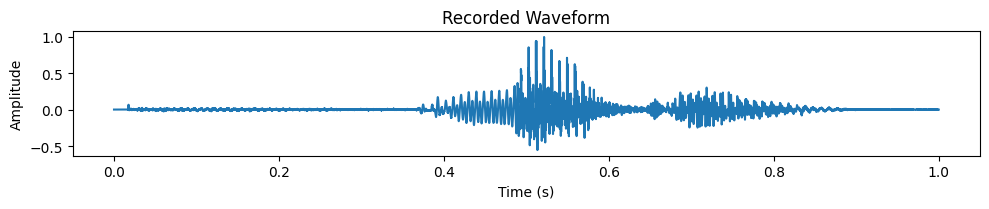

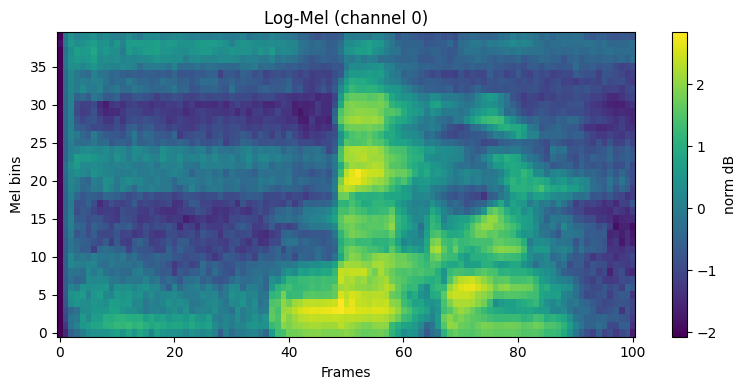


>>> FINAL PREDICTION: backward  (confidence=0.954)


In [78]:
wav_path = record_audio(seconds=1.2, out_wav="/content/mic.wav")
pred, conf = predict_wav(wav_path, topk=5, plot=True)
print(f"\n>>> FINAL PREDICTION: {pred}  (confidence={conf:.3f})")